# BACKTESTING & ANALYSIS: CROSS-SECTIONAL MOMENTUM

OUTLINE:

ANALYSIS PREPARATION:
- Import modules
- Set stable parameters
- import and clean data

FACTOR ANALYSIS:
- Visualize raw factor scores
- Normalize factor scores
- Conduct Information Coefficient Analysis (Spearman and Pearson Correlation)
- Calculate factor decay
- Calculate factor turnover

QUANTILE ANALYSIS:
- Split normalized factor scores into quantiles
- Calculate and examine quantile performance statistics
- Calculate quantile annual holdings turnover
- Calculate & examine quantile performance stats for different factor parameters

### ANALYSIS PREPARATION

#### IMPORT LIBRARIES

To keep the notebook clean, I have created a repository of the functions ("BackTestAnalytics"). This eventually could turn to a general registry package. For now, to use the function, you will have to added directly from my github. 

using Pkg

Pkg.add(url="https://github.com/georgegee23/BackTestAnalytics.jl.git")

Pkg.instantiate()


In [3]:
using BackTestAnalytics
using XLSX, DataFrames, DataFramesMeta, Dates 
using Statistics, StatsBase

using Plots, GR
theme(:dark)

#### SET PARAMETERS FOR SIMULATION

In [4]:
# We are using monthly data, let's set our annual period to 12
periods_per_year = 12

12

#### IMPORT & CLEAN DATA

In [5]:
# Location and names of files

loc = "E:\\SEGResearch\\Research\\BackTesting\\sp500\\Finalized\\"

sp500_holdings_returns = "202408_SPY_ME_RETS.xlsx"
bk_returns = "202408_BK_ME_RETS.xlsx"

"202408_BK_ME_RETS.xlsx"

In [6]:
#Import data
returns_table = XLSX.readtable(loc*sp500_holdings_returns, "Sheet1")
bk_returns_table = XLSX.readtable(loc*bk_returns, "Sheet1")

#Creat DataFrames
returns_df = DataFrame(returns_table) 
bk_returns_df = DataFrame(bk_returns_table)

Row,Date,SPY-US,RSP-US,VTI-US,SPXEKW
,Any,Any,Any,Any,Any
1,1998-02-28,0.0692943,missing,missing,0.0765698
2,1998-03-31,0.0457789,missing,missing,0.0487599
3,1998-04-30,0.0127914,missing,missing,0.00224555
4,1998-05-31,-0.020769,missing,missing,-0.0277368
5,1998-06-30,0.0392662,missing,missing,0.00991416
6,1998-07-31,-0.0135135,missing,missing,-0.0452672
7,1998-08-31,-0.14118,missing,missing,-0.15066
8,1998-09-30,0.0598959,missing,missing,0.0543036
9,1998-10-31,0.081081,missing,missing,0.0856398


In [7]:
#convert date column to Date
returns_df.Date = convert.(Date, returns_df.Date)
bk_returns_df.Date = convert.(Date, bk_returns_df.Date)

#Align start period of security and benchmark returns with beacktest universe
bk_returns_df = bk_returns_df[bk_returns_df.Date .>= returns_df.Date[1], ["Date", "SPY-US"]]

#Extract and format DataFrames
DATES = returns_df.Date
SECURITY_IDS = names(returns_df)[2:end]
SECURITY_RETURNS = returns_df[:, Not(:Date)]
BENCHMARK_RETURNS =  Vector{Union{Missing, Float64}}(bk_returns_df[:, "SPY-US"])

# Check to see if the Dimensions are consistent.
println("Dimensions:", size(SECURITY_RETURNS), size(BENCHMARK_RETURNS))

Dimensions:(270, 1017)(270,)


### FACTOR ANALYSIS: CROSS-SECTIONAL MOMENTUM

Let's create a function to compute our factor scores. In this case, we will be calculating the risk-adjusted momentum. 

The function:
1. Calculate synthetic equity prices from returns data.
2. Calculate percentage change for a given window.
3. Optional: Shift percentage change dataframe to account for short-term reversal effect.

In [8]:
#We define the function to help us compute our factor scores

function calculate_momentum(returns::DataFrame, window:: Int, reversal_period::Int = 0)

    prices = returns_to_prices(returns)
    pct_chg = percentage_change(prices, window)

    # To account for the Short-Term Reversal Effect, we want to be able to
    # shift percentage change by the reversal period
    shifted_pct_chg = shift_dataframe(pct_chg, shift = reversal_period) 

    return shifted_pct_chg
    
end

window = 12
reversal_period = 0
factor_scores = calculate_momentum(SECURITY_RETURNS, 12, 0)

Row,037833100,594918104,67066G104,023135106,30303M102,02079K305,084670702,02079K107,532457108,11135F101,46625H100,88160R101,91324P102,30231G102,92826C839,742718109,478160104,57636Q104,22160K105,437076102,00287Y109,931142103,64110L106,58933Y105,191216100,060505104,00724F101,166764100,79466L302,007903107,713448108,883556102,G54950103,68389X105,G1151C101,580135101,17275R102,949746101,002824100,747525103,882508104,718172109,369604301,459200101,031162100,235851102,461202103,92343V104,81762P102,46120E602,149123101,65339F101,254687106,38141G104,78409V104,038222105,717081103,75513E101,907818108,20030N101,90353T100,743315103,025816109,00206R102,548661107,438516106,20825C104,872540109,09857L108,617446448,036752103,92532F100,09247X101,75886F107,G29183103,863667101,539830109,101137107,172967424,74340W103,G5960L103,697435105,032654105,H1467J104,053015103,571748102,482480100,855244109,512807108,595112103,03027X100,125523100,872590104,337738108,09260D107,110122108,654106103,244199105,097023105,375558103,⋯
,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,⋯
1,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,⋯
2,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,⋯
3,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,m

#### VISUALIZE FACTOR SCORES

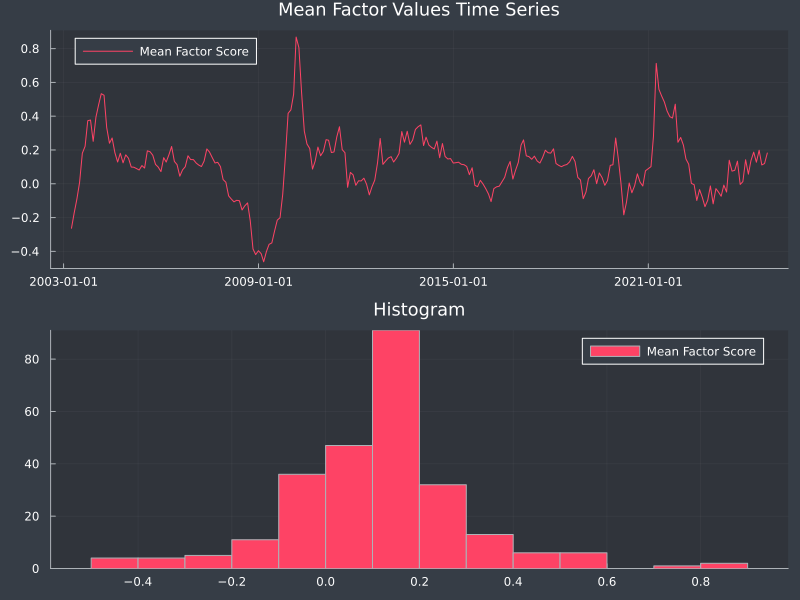

In [9]:
plot_factor_distribution(factor_scores[1+window:end, :], DATES[1+window:end])

We can see that the mean factor scores of securities declined in periods of market downturns like 2008. 

Let's look at the raw factor score for Apple Inc (AAPL), cusip 037833100.

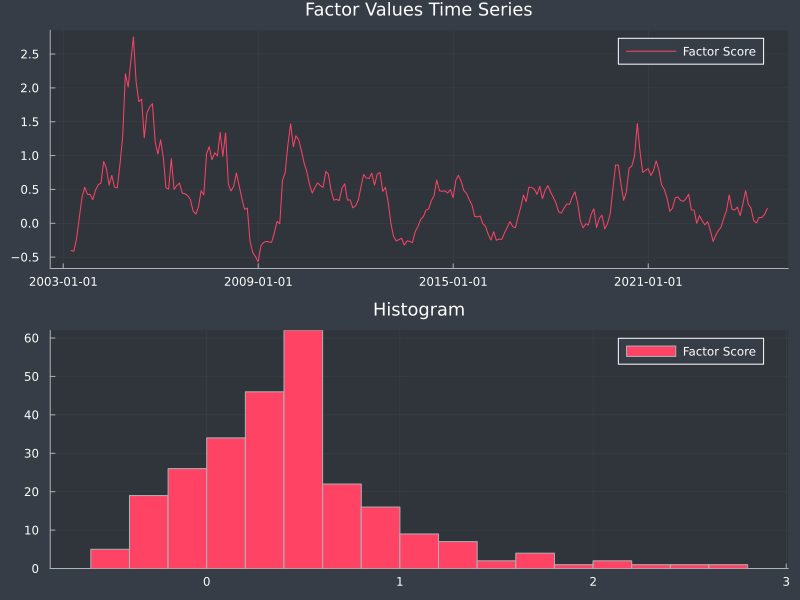

In [10]:
cusip = "037833100"
plot_factor_distribution(factor_scores[1+window:end, cusip], DATES[1+window:end])

Apple's historical momentum score is highly skewed in a positive direction. 

#### NORMALIZE FACTOR SCORES USING PERCENTILES

There are various methods for normalizing data. Standard industry practice is to use z-scores, but I will use percentile rank here.

The percentile rank is a non-parametric statistic, meaning it does not make assumptions about the underlying distribution of the data. It describes the position of a value within any dataset, regardless of whether it's normal, skewed, bimodal, or any other shape.

In [11]:
# Normalize data using percentile rank on DataFrame rows. 

factor_perc = rowwise_percentiles(factor_scores[window+1:end, :])

# #Check data
row_max = map(row -> maximum(skipmissing(row)), eachrow(factor_perc)) |> x -> round.(x, digits = 2)
row_mean = map(row -> mean(skipmissing(row)), eachrow(factor_perc))   |> x -> round.(x, digits = 2)
row_min = map(row -> minimum(skipmissing(row)), eachrow(factor_perc)) |> x -> round.(x, digits = 2)

percentile_check = [row_max, row_mean, row_min]

3-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

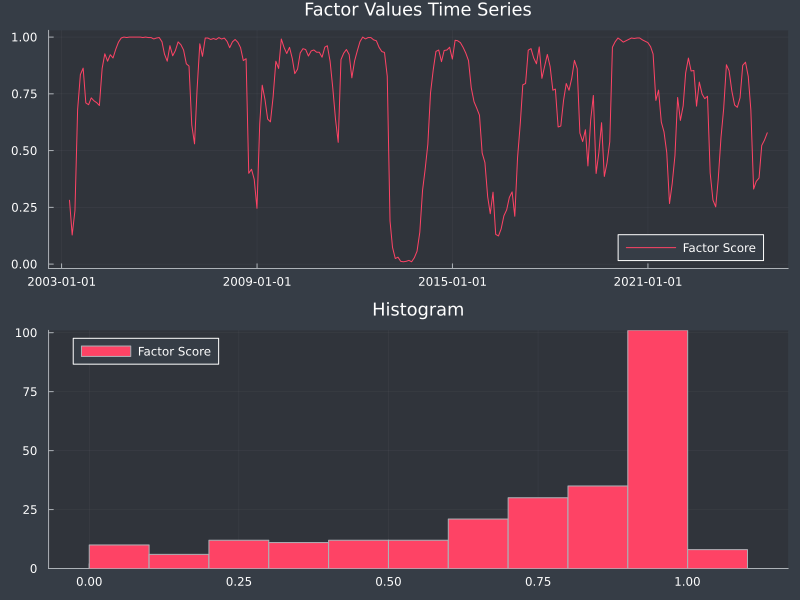

In [12]:
#Visualize Apple Inc
cusip = "037833100"
plot_factor_distribution(factor_perc[:, cusip], DATES[window+1:end])

Unsurprisingly, Apple Inc. has spent much time near the top percentile. 

#### SPEARMAN RANK & PEARSON CORRELATION (INFORMATION COEFFICIENT ANALYSIS)

Next, we will lag our factor percentile scores one period back (one month). The Spearman correlation will tell us how correlated the month's returns are to the prior month's factor percentile score. 

In [13]:
shift = 1
factor_perc_lag = shift_dataframe(factor_perc[1:end,:], shift = shift)[1+shift:end,:]
w_returns = SECURITY_RETURNS[1+window+shift:end, :]

#Let's check of the dimension of our data match
size(factor_perc_lag), size(w_returns)

((257, 1017), (257, 1017))

In [14]:
cs_spearmanr(factor_perc_lag, w_returns)

0.004125243341847017

There is a slight positive correlation between the 12-month momentum scores and subsequent monthly returns, but overall, that correlation is very low. Let's also look at the correlation on a 1-year rolling basis. 

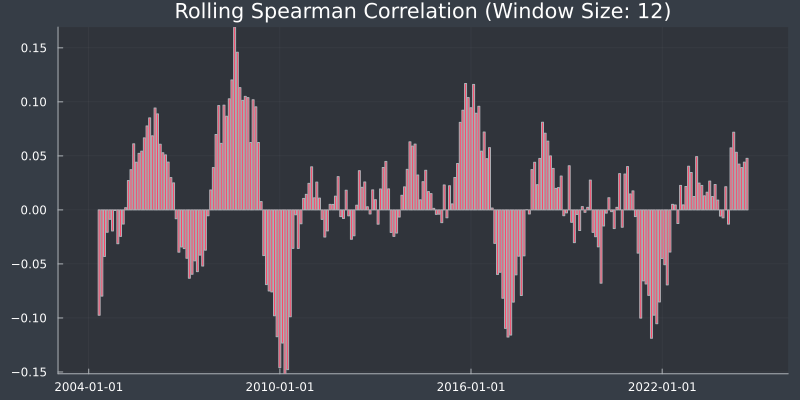

In [15]:
roll_window = 12

plot_rolling_cs_spearmanr(factor_perc_lag, w_returns, 
    DATES[1+window+roll_window+shift:end], roll_window)

The Spearman correlation is not highly consistent on a 1-year rolling basis. There were times when the correlation between factor percentiles and subsequent returns was negative.   

Let's compute the Spearman correlation for more windows and visualize it. Let's calculate each window's risk-adjusted momentum, convert it to a percentile, and then shift it back one month. 

In [16]:
lag = 1
reversal_period = 0

window_mean_spearman_corrs = Dict{Int, Float64}()

for w in 1:48

    w_factor = calculate_momentum(SECURITY_RETURNS, w, reversal_period)[1+w+reversal_period:end,:]
    w_factor_perc = rowwise_percentiles(w_factor)

    #Shift the factors to align with subsequent return
    w_factor_perc_lag = shift_dataframe(w_factor_perc, shift = lag)[1+lag:end,:]
    #Select aligning returns
    w_returns = SECURITY_RETURNS[1+w+reversal_period+lag:end,:]
    
    window_mean_spearman_corrs[w] = cs_spearmanr(w_factor_perc_lag, w_returns)
end

window_mean_spearman_corrs = sort(window_mean_spearman_corrs)

OrderedCollections.OrderedDict{Int64, Float64} with 48 entries:
  1  => -0.0133828
  2  => -0.0140871
  3  => -0.00569025
  4  => -0.00614165
  5  => -0.00168654
  6  => 0.00335364
  7  => 0.00201631
  8  => 0.00655909
  9  => 0.00877618
  10 => 0.0081641
  11 => 0.00927404
  12 => 0.00412524
  13 => 0.00406023
  14 => 0.00425892
  15 => 0.00550483
  16 => 0.00596126
  17 => 0.00758342
  18 => 0.00727989
  19 => 0.00929959
  ⋮  => ⋮

Pearson correlation is affected by outliers, but let's plot it and compute it, as well:

In [17]:
lag = 1
window_mean_pearson_corrs = Dict{Int, Float64}()

for w in 1:48
    
    w_factor = calculate_momentum(SECURITY_RETURNS, w, reversal_period)[1+w+reversal_period:end,:]
    w_factor_perc = rowwise_percentiles(w_factor)
    w_factor_perc_lagged = shift_dataframe(w_factor_perc, shift = lag)[1+lag:end,:]
    
    w_returns = SECURITY_RETURNS[1+w+lag:end,:]
    
    # we start at row 2 since the first row in the lagged dataframe will be all missing values
    window_mean_pearson_corrs[w] = cs_pearsonr(w_factor_perc_lagged, w_returns)
end

window_mean_pearson_corrs = sort(window_mean_pearson_corrs)

OrderedCollections.OrderedDict{Int64, Float64} with 48 entries:
  1  => -0.0115746
  2  => -0.0116974
  3  => -0.0026411
  4  => -0.00297195
  5  => 0.00169329
  6  => 0.00718502
  7  => 0.00652742
  8  => 0.00972424
  9  => 0.011127
  10 => 0.0110187
  11 => 0.0112628
  12 => 0.00607555
  13 => 0.00565342
  14 => 0.00533285
  15 => 0.00621845
  16 => 0.00591901
  17 => 0.00818304
  18 => 0.00738017
  19 => 0.00914816
  ⋮  => ⋮

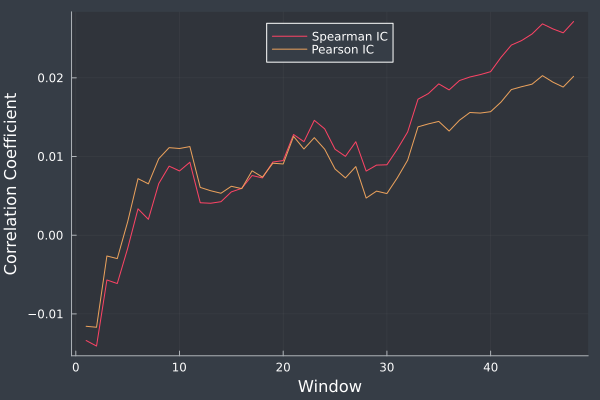

In [18]:
# Plot the spearman rank and pearson correlation coefficient for each window size
windows_vec = collect(keys(window_mean_spearman_corrs))
spearman_corrs_vec = collect(values(window_mean_spearman_corrs))
pearson_corr_vec = collect(values(window_mean_pearson_corrs))

Plots.plot(windows_vec, 
[spearman_corrs_vec pearson_corr_vec], labels = ["Spearman IC" "Pearson IC"], 
legend=:top, xlabel = "Window", ylabel = "Correlation Coefficient")

The correlation between factor percentile scores and subsequent returns is negative for anything below a 6-month window and particularly negative at the 1 and 2-month levels. This is probably due to what is known as momentum's Short-Term Reversal Effect. It typically occurs when stocks have experienced extreme price changes in a very short period and reverse direction. 

Let's do the same and avoid using the two most recent percentage change data (12M-2M). This will make our momentum function more consistent with the MOM factor from the Fame-French model. 

In [19]:
window, lag, reversal_period = 12, 1, 2

factor_scores = calculate_momentum(SECURITY_RETURNS, window, reversal_period)[1+window+reversal_period:end, :]
factor_perc = rowwise_percentiles(factor_scores)
factor_perc_lagged = shift_dataframe(factor_perc, 
    shift = lag)[1+lag:end, :]
returns = SECURITY_RETURNS[1+window+reversal_period:end, :]

cs_spearmanr(factor_perc_lagged, returns[1+lag:end,:])

0.008605047164879212

We can see that using 12M-2M more than doubled the Spearman ranked correlation, going from 0.00412 to 0.00861. 

#### FACTOR DECAY

Factor decay measures the decline in a factor's predictive power as the forecasting horizon (or backtesting history) is extended.

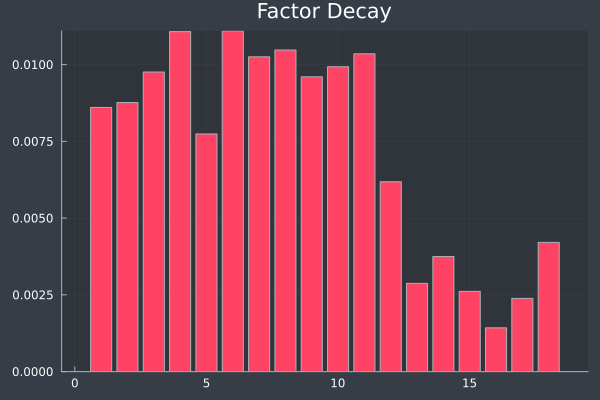

In [20]:
plot_factor_decay(factor_perc, returns, 18)

It look's like the factor's predictive power declines after 11 months. 

#### FACTOR TURNOVER (AUTOCORRELATION)

To isolate the effect of factor changes from portfolio construction, signal autocorrelation (i.e., serial correlation is commonly used to measure factor turnover. Signal autocorrelation is computed as the correlation between the vector of today's (t) factor scores and the factor scores from the preceding period (t – 1):

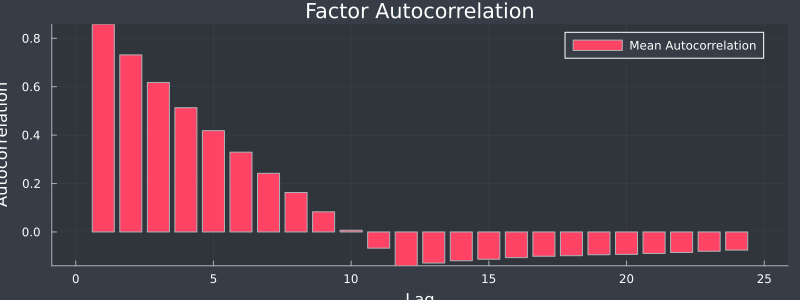

In [21]:
lags = 1:24

plot_factor_autocor(factor_perc, lags)

The momentum factor has a high turnover rate. One way to reduce that turnover could be to extend the window. Let's consider a 24-month momentum window. 

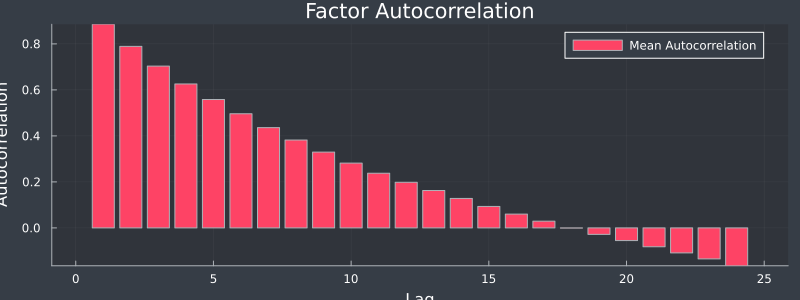

In [22]:
window, reversal_period = 24, 2
factor_scores_24M = calculate_momentum(SECURITY_RETURNS, window, reversal_period)
factor_perc_24M = rowwise_percentiles(factor_scores_24M)

lags = 1:24
plot_factor_autocor(factor_perc_24M, lags)

Let's also take a look at the rolling factor autocorrelation. 

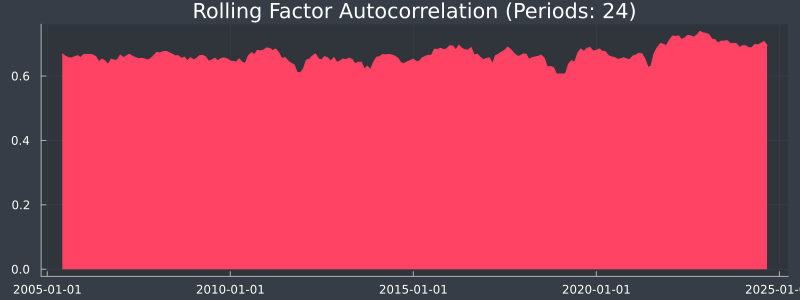

In [23]:
window, reversal_period = 12, 2
factor_scores = calculate_momentum(SECURITY_RETURNS, window, reversal_period)[1+window+reversal_period:end, :]
factor_perc = rowwise_percentiles(factor_scores)

acf_window = 24
roll_acf = rolling_acf(factor_perc, acf_window)

x_dates = DATES[1 + window + acf_window+reversal_period:end]
y_values = collect(values(sort(roll_acf)))

Plots.areaplot(x_dates, y_values,
title =  "Rolling Factor Autocorrelation (Periods: $acf_window)", 
label = "", legend = :topright, 
size = (800,300)
)

### QUANTILE ANALYSIS

#### QUANTILE PERFORMANCE COMPARISON

Another way to examine a factor's performance is to break up security factor score percentiles into different lagged quantiles and examine the performance of each quantile. 

First, let's check how many securities we should expect for each quantile:

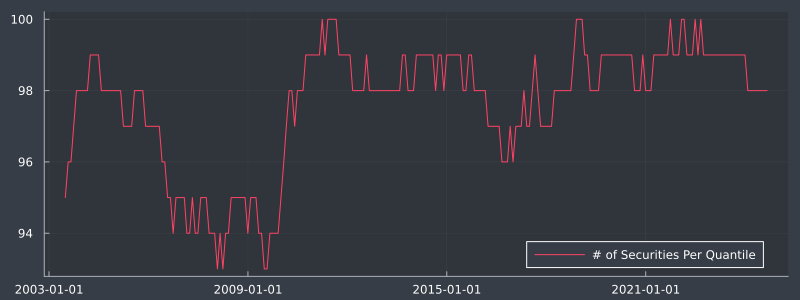

In [24]:
window, reversal_period = 12, 2
factor_scores = calculate_momentum(SECURITY_RETURNS, window, reversal_period)[1+window+reversal_period:end, :]
factor_perc = rowwise_percentiles(factor_scores)

lag = 1

w_returns = SECURITY_RETURNS[1+window+reversal_period+lag:end,:]

quantiles_n5 = rowwise_ntiles(factor_perc, 5) 
quantiles_n5_lag = shift_dataframe(quantiles_n5, shift = lag)[1+lag:end, :] # Compute the quantiles and shift them to aligh with the subsequent month's return

# Securitieis per quantile
plot_securities_per_quantile(quantiles_n5_lag, DATES[1+window+reversal_period+lag:end,:]; 
labels = "# of Securities Per Quantile", size = (800,300))

Next, let's calculate performance statistics for the quantiles and visualize them:

8×6 DataFrame
 Row │ Stat             Q1         Q2        Q3         Q4        Q5        
     │ String           Float64    Float64   Float64    Float64   Float64   
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Annual Return      7.74344   10.2394    9.78003   10.0762    8.90879
   2 │ Annual StDev      24.9938    17.8249   15.5675    15.0698   16.4906
   3 │ Sharpe Ratio      30.9814    57.4447   62.8233    66.8637   54.0235
   4 │ Sortino Ratio     12.5587    17.4185   17.9684    17.7332   15.6287
   5 │ Max Drawdowns     75.155     55.6187   49.7672    45.028    53.509
   6 │ Down Capture     145.867    107.859    96.3591    90.055    97.0001
   7 │ Up Capture       133.086    112.917   102.58      99.5014  100.343
   8 │ Overall Capture   91.2378   104.689   106.456    110.49    103.446


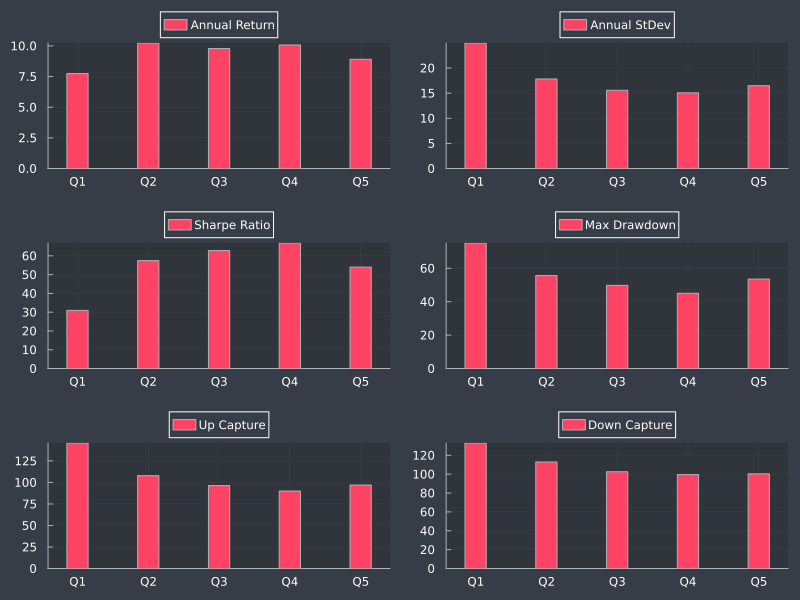

In [25]:
quantiles_n5_returns = compute_quantile_returns(quantiles_n5_lag, w_returns)
quantile_n5_table = quantile_performance_table(quantiles_n5_returns, 
BENCHMARK_RETURNS[1+window+reversal_period+lag:end]; periods_per_year = periods_per_year)

println(quantile_n5_table)
quantile_n5_table |> plot_performance_table

Next, plot the growth and drawdowns of the quantiles:

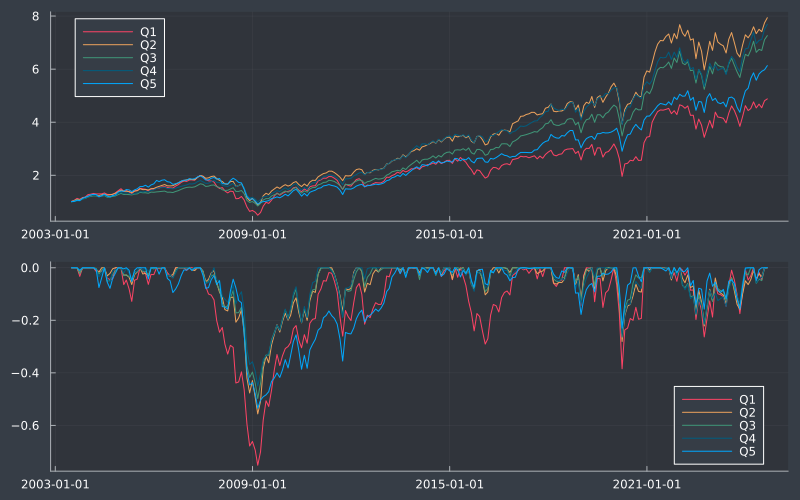

In [26]:
plot_performance_timeseries(quantiles_n5_returns, DATES[1+window+reversal_period+lag:end])

Quantile 1 (least momentum) underperforms on an absolute and risk-adjusted basis. However, all the other quantiles performed well. 

#### QUANTILE HOLDINGS TURNOVER

We should examine the expected quantile turnover of our factor:

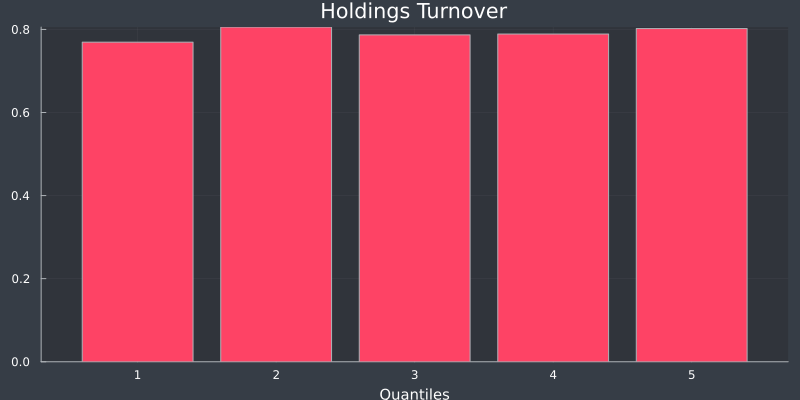

In [27]:
hlds_turnover = quantiles_holdings_turnover(quantiles_n5, 12)
Plots.bar(keys(hlds_turnover) |> collect, values(hlds_turnover) |> collect, 
    labels = "", size = (800,400), title = "Holdings Turnover", xlabel = "Quantiles", guidefontsize=10)

We can expect around 80% annual turnover from our factor. 

Let's see if increasing the window decreases holdings turnover:

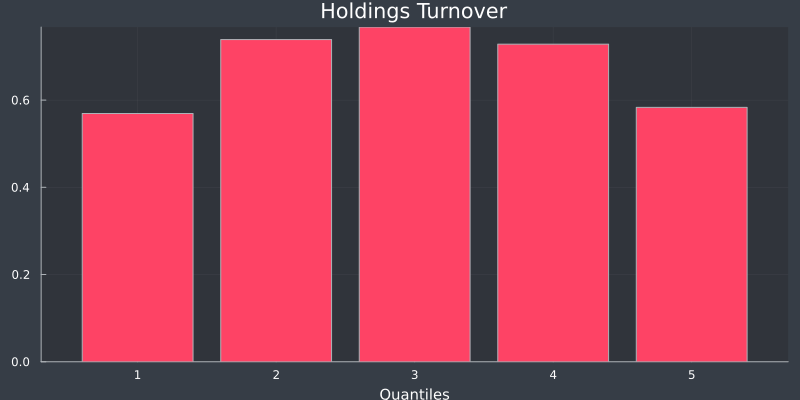

In [28]:
window, reversal_period = 24, 2
factor_scores = calculate_momentum(SECURITY_RETURNS, window, reversal_period)[1+window+reversal_period:end, :]
factor_perc = rowwise_percentiles(factor_scores)

lag = 1

w_returns = SECURITY_RETURNS[1+window+reversal_period+lag:end,:]

quantiles_n5 = rowwise_ntiles(factor_perc, 5) 

hlds_turnover = quantiles_holdings_turnover(quantiles_n5)
Plots.bar(keys(hlds_turnover) |> collect, values(hlds_turnover) |> collect, 
    labels = "", size = (800,400), title = "Holdings Turnover", xlabel = "Quantiles", guidefontsize=10)

Our expected turnover declines, which is consistent with the factor turnover analysis. 

#### RISK & RETURN STATISTICS FOR DIFFERENT RISK-ADJUST MOMENTUM TIME FRAMES

Here, we will plot some of the risk statistics based on the momentum window:

In [29]:
reversal_period = 2
lag = 1
n_quantiles = 5
periods_per_year = 12

quantile_names = ["Q"*string(i) for i in 1:n_quantiles]

annual_returns_dict = Dict{Int64, Vector{Float64}}()
annual_std_dict = Dict{Int64, Vector{Float64}}()
sharpe_ratio_dict = Dict{Int64, Vector{Float64}}()  
max_dds_dict = Dict{Int64, Vector{Float64}}()
uc_ratio_dict = Dict{Int64, Vector{Float64}}() 
dc_ratio_dict = Dict{Int64, Vector{Float64}}()


for w in 3:48   

    w_factor_scores = calculate_momentum(SECURITY_RETURNS, w, reversal_period)[1+w+reversal_period:end, :]
    w_factor_perc = rowwise_percentiles(w_factor_scores)
    w_factor_perc_lag = shift_dataframe(w_factor_perc; shift = lag)[1+lag:end,:]

    w_returns = SECURITY_RETURNS[1+w+reversal_period+lag:end,:]
    w_bk_returns = BENCHMARK_RETURNS[1+w+reversal_period+lag:end,:]

    quantiles = rowwise_ntiles(w_factor_perc_lag, n_quantiles) # Compute the quantiles from the lagged factors
    quantile_rets = DataFrame(compute_quantile_returns(quantiles, w_returns))

    annual_returns_dict[w] = annual_return(quantile_rets, periods_per_year)
    annual_std_dict[w] = annual_stdev(quantile_rets, periods_per_year)
    sharpe_ratio_dict[w] = annual_sharpe_ratio(quantile_rets, periods_per_year)
    max_dds_dict[w] = max_drawdown(quantile_rets)
    uc_ratio_dict[w] = up_capture(quantile_rets[2:end,:], w_bk_returns[2:end], 0)
    dc_ratio_dict[w] = down_capture(quantile_rets[2:end,:], w_bk_returns[2:end], 0)

end

window_stat_dict = Dict{String, DataFrame}()
window_stat_dict["Annual Return"] = dict_to_rowframe(annual_returns_dict, quantile_names)
window_stat_dict["Annual StDev"] = dict_to_rowframe(annual_std_dict, quantile_names)
window_stat_dict["Sharpe Ratio"] = dict_to_rowframe(sharpe_ratio_dict, quantile_names)
window_stat_dict["Max Drawdown"] = dict_to_rowframe(max_dds_dict, quantile_names)
window_stat_dict["Up Capture"] = dict_to_rowframe(uc_ratio_dict, quantile_names)
window_stat_dict["Down Capture"] = dict_to_rowframe(dc_ratio_dict, quantile_names)
window_stat_dict

Dict{String, DataFrame} with 6 entries:
  "Sharpe Ratio"  => 46×6 DataFrame…
  "Max Drawdown"  => 46×6 DataFrame…
  "Annual Return" => 46×6 DataFrame…
  "Up Capture"    => 46×6 DataFrame…
  "Annual StDev"  => 46×6 DataFrame…
  "Down Capture"  => 46×6 DataFrame…

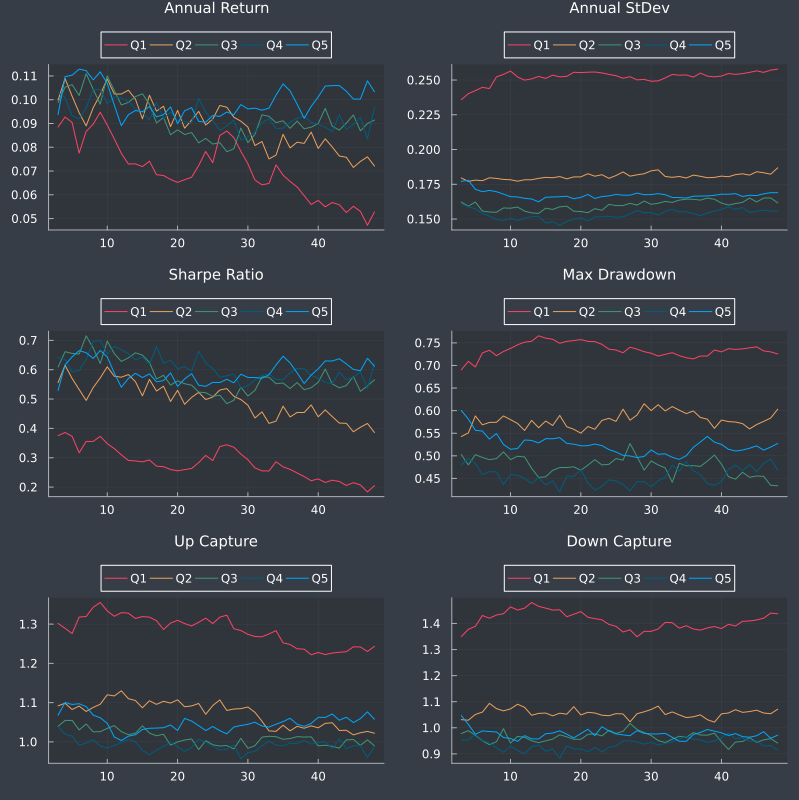

In [30]:
plots_dict = Dict{String, Plots.Plot}()
n_quantiles = ncol(window_stat_dict["Annual Return"])
names_quantiles = names(window_stat_dict["Annual Return"][:, Not("Key")])
names_quantiles = permutedims(names_quantiles)

for (stat_name, df) in pairs(window_stat_dict)

    x_axis = @view df[:, "Key"]
    y_axis = Matrix(df[:, Not("Key")])
    plots_dict[stat_name] = Plots.plot(x_axis, y_axis; size = (600, 300),
    title = stat_name, titlefontsize=10, labels = names_quantiles)
end

theme(:dark)

# Combine all plots
layout = (3,2)
combined_plot = Plots.plot(plots_dict["Annual Return"], plots_dict["Annual StDev"], plots_dict["Sharpe Ratio"], 
plots_dict["Max Drawdown"], plots_dict["Up Capture"], plots_dict["Down Capture"], 
layout=layout, legend=:outertop, legendcolumns=5, size=(800, 800))

Quantile 1 (with the least momentum) underperforms the other quantiles on almost all measures for our momentum percentile score (12-2M). Nonetheless, the other four quantiles performed well during the examined period. 